In [1]:
import csv
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import arff
import pandas as pd
import scipy.stats as stats
import seaborn as sns
sns.set(style="dark")
import pywt
from scipy.special import erfcinv
from scipy.signal import butter, convolve

from tqdm import tqdm

# Algorithms

In [2]:
def iterativeWaveletDenoising( signal, waveletname, level, alpha_1, mode = "soft"):
    coeffs = pywt.wavedec(signal, waveletname, level = level) 


    details = coeffs[1:]

    new_details = []

    alpha = alpha_1

    for detail in details:
        new_detail = detail.copy()
        s = np.std(detail, ddof=0)
        d = np.sqrt(2) * erfcinv(alpha)
        while (np.abs(detail) > s*d).any():
            indices_to_delete = np.argwhere(np.abs(detail) > s*d)
            detail = np.delete(detail, indices_to_delete)
            s = np.std(detail)



            
        threshold = s*d

        new_detail = pywt.threshold(new_detail, threshold, mode=mode)
        new_details.append(new_detail)
        alpha += alpha_1

    new_coeffs = [coeffs[0]] + new_details
    denoised_signal = pywt.waverec(new_coeffs, waveletname)

    return denoised_signal


def baselineWaveletDenoising(signal, waveletname, level, threshold_percent= 0.9, mode = "soft"):
    coeffs = pywt.wavedec(signal, waveletname, level = level) 
    details = coeffs[1:]
    new_details = []
    for detail in details:
        #Méthode de base : on prend le seuil à 0.9*max (tous ceux en dessous sont tronqués)
        threshold = threshold_percent*np.max(detail)
        new_detail = pywt.threshold(detail, threshold, mode="soft")
        new_details.append(new_detail)

    new_coeffs = [coeffs[0]] + new_details
    denoised_signal = pywt.waverec(new_coeffs, waveletname)

    return denoised_signal

In [3]:
def metrics(signal, denoised_signal):

    #MSE
    rmse = np.mean((signal - denoised_signal)**2)**0.5

    #SNR
    snr = 10*np.log10(np.var(signal)/np.var(signal - denoised_signal))

    prd = np.sqrt( (np.sum(np.square(signal - denoised_signal))) / (np.sum(np.square(signal))))

    d_max = np.max (np.abs(signal - denoised_signal))

    return rmse, snr, prd, d_max

In [4]:
def mdct_atoms(signal, L, k):
    """
    Returns the MDCT atom for a scale L  and frequency k, 0-padded to match the length of the signal.

    Parameters
    ----------
    signal : array_like, shape (N,)
        The signal to be represented.
    L : int
        The scale of the MDCT atom.
    k : int
        The frequency of the MDCT atom.

    Returns
    -------
    array_like, shape (N,)
        The MDCT atom for a scale L (length 2L)  and frequency k, 0-padded to match the length of the signal.
    """
    N = len(signal)
    u = np.arange(0, 2*L - 1, 1)
    res = np.sin(np.pi * (u +0.5) / (2*L)) * np.sqrt(2/L) * np.cos( (np.pi /L) * (u + 0.5*(L+1)) * (k + 0.5) )
    if N > 2*L - 1:
        return np.hstack((res, np.zeros(N - (2*L - 1))))
    return

def buildDictionary(signal, Ls):
    """
    Returns the whole dictionary of MDCT atoms for a given signal and list of scale Ls.

    Parameters
    ----------
    signal : array_like, shape (N,)
        The signal to be represented.
    Ls : list
        The list of scales for the MDCT atoms.

    Returns
    -------
    array_like, shape (N, len(Ls))
        The whole dictionary of MDCT atoms for a given signal and list of scale Ls.
    """

    N = len(signal)
    dictionary = np.zeros((N, 1))
    for L in Ls:
        for k in range(L):
            dictionary = np.hstack((dictionary, mdct_atoms(signal, L, k).reshape((N, 1))))
    return dictionary[:, 1:]

def orthogonalMatchingPursuit(signal, D, K):
    """
    Returns the indices of the K atoms of the dictionary D that best match the signal.

    Parameters
    ----------
    signal : array_like, shape (N,)
        The signal to be represented.
    D : array_like, shape (N, M)
        The dictionary of MDCT atoms.
    K : int
        The number of atoms to select.

    Returns
    -------
    support: array_like, shape (N, K)
        The indices of the K atoms of the dictionary D that best match the signal. Each atom is a column of D suitably shifted, see "Placement" in the code.
    norm_residuals: array_like, shape (K+1,)
        The norm of the residual at each iteration.
    reconstruction: array_like, shape (N,)
        The reconstruction of the signal (projection over the selected atoms)
    """
    N = len(signal)
    residual = signal
    norm_residuals = [np.linalg.norm(residual)]
    support = np.empty((N, K))
    flipDic = np.flipud(D)
    for _ in range(K):
        #We compute the full convolution of each atom with the signal
        convolutions = np.abs(convolve(residual.reshape(-1,1), flipDic, mode='full')) #shape (4095, 2016)
        correlations = np.max(convolutions,axis=0) #shape (2016,). We take the max of each column (correlation of each atom = max of the convolution)
        index_atom = np.argmax(correlations) #Best correlation

        #"Placement" of the atom in a (2048, ) vector
        start=np.argmax(convolutions[: , index_atom])
        begin=max(start-(N-1),0)
        end =min(start,N-1)

        atom=np.hstack((np.zeros(begin),D[begin+(N-1)-start:end+(N-1)-start,index_atom],np.zeros(N-end)))

        #Update support
        support[:, _] = atom.reshape((N, ))
        support[:, :_] /= np.linalg.norm(support[:, :_], axis = 0) #Normalization, because we will project using pseudo-inverse

        #Update residual
        S = support[:, :_+1]

        try :
            STS_inv = np.linalg.inv(S.T@S)
        except np.linalg.LinAlgError:
            eps = 10**(-6)
            STS_inv = np.linalg.inv(S.T@S + eps*np.eye(S.shape[1]))
        reconstruction = S@STS_inv@S.T@signal
        residual = signal - reconstruction
        norm_residuals.append(np.linalg.norm(residual))

    return support, norm_residuals, reconstruction




# Data loading

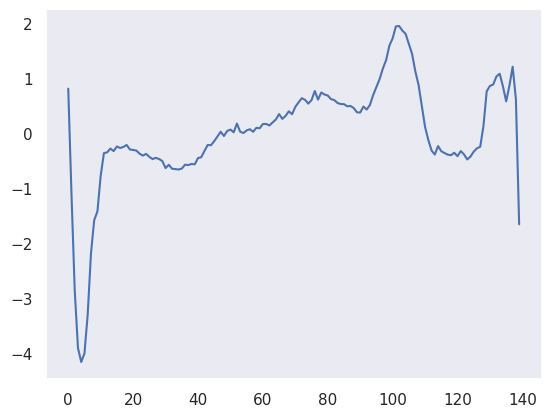

In [5]:
#Importation of signal 
# Load ARFF file
data, meta = arff.loadarff('ECG5000_TRAIN.arff')

# Convert to DataFrame
df = pd.DataFrame(data)
df = df[df['target'] == b'1'].copy() #keep only the first class
df.drop('target', axis=1, inplace=True) #drop the class number

i = 16
line = df.iloc[i]

line = line.astype(float).tolist()

#Normalize signal
line = line

plt.plot([i for i in range(len(line))],line)
plt.show()

In [6]:
np.linalg.norm(line)/np.sqrt(len(line))

0.9964221728725383

(140,)
0.3247211234346446


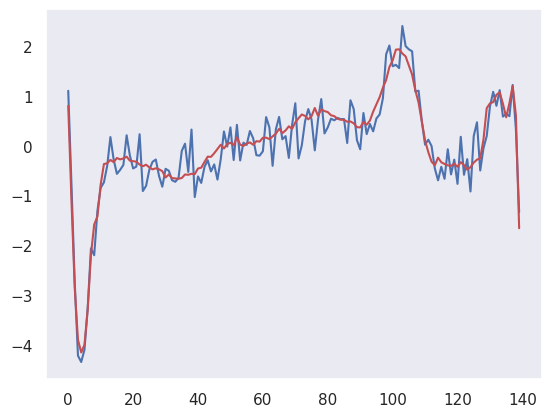

In [7]:
def addNoise(line, SNR):
    log_ratio = SNR / 10
    noise_variance = np.var(line) / (10 ** log_ratio)
    noise = np.sqrt(noise_variance) * np.random.randn(len(line))
    return line + noise, noise_variance, noise

def addNoise2(line, noise_var):
    noise = np.sqrt(noise_var) * np.random.randn(len(line))
    SNR = 10 * np.log10(np.var(line) / np.var(noise))
    return line + noise, SNR, noise
20
noisy_line, _, noise = addNoise(line, 10)
plt.plot(noisy_line)
plt.plot(line, 'r')

print(noisy_line.shape)

rmse, snr, prd, d_max = metrics(line, noisy_line)
print(rmse)

# Algorithms test

In [8]:
levels = [2,3,4]
res = np.zeros((len(pywt.wavelist()), len(levels)))
best_prd = 1

for i, waveletname in tqdm(enumerate(pywt.wavelist(kind = 'discrete'))):
    for j, level in enumerate(levels):
        denoised_line = iterativeWaveletDenoising(noisy_line, waveletname, level, 0.01)
        mse, snr, prd, d_max = metrics(line, denoised_line)
        res[i, j] = prd
        if prd < best_prd:
            best_prd = prd
            best_wavelet = waveletname
            best_level = level
        
print("--------------")
print(best_prd)
print(best_wavelet)
print(best_level)
    

1it [00:00,  6.96it/s]/home/max/.local/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
7it [00:00, 32.92it/s]/home/max/.local/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(
20it [00:00, 51.77it/s]/home/max/.local/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
106it [00:01, 77.73it/s] 

--------------
0.1997330707027988
rbio3.9
2


In [9]:
np.argmin(res[res > 0.1])

249

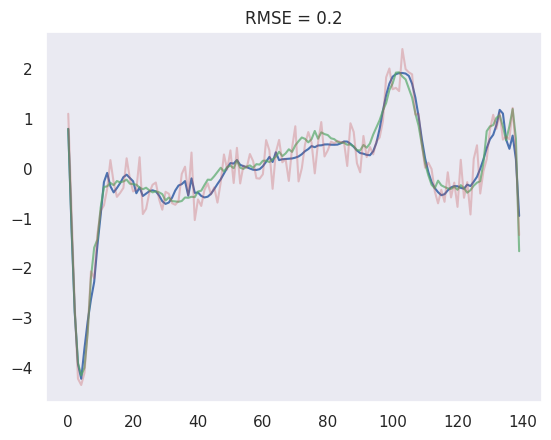

In [10]:
denoised_line = iterativeWaveletDenoising(noisy_line, best_wavelet, best_level, 0.015)
mse, snr, prd, d_max = metrics(line, denoised_line)
plt.plot(denoised_line)
plt.plot(line, 'g', alpha = 0.7)
plt.plot(noisy_line, 'r', alpha = 0.3)
plt.title("RMSE = " + str(round(mse,2)))
plt.show()

100%|██████████| 20/20 [00:00<00:00, 583.73it/s]

Best threshold :  0.19473684210526315


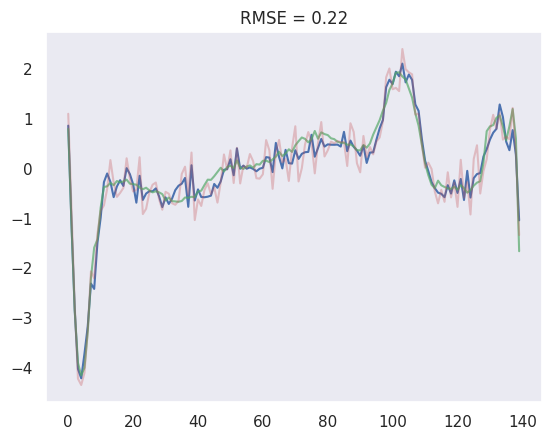

In [11]:
threshold_percents = np.linspace(0.1, 1, 20)

best_prd = 1

for thresh in tqdm(threshold_percents):
    denoised_line = baselineWaveletDenoising(noisy_line, best_wavelet, best_level, thresh)
    mse, snr, prd, d_max = metrics(line, denoised_line)
    if prd < best_prd:
        best_prd = prd
        best_thresh = thresh

print("Best threshold : ", best_thresh)
denoised_line = baselineWaveletDenoising(noisy_line, best_wavelet, best_level, best_thresh) #j'ai remplace tresh par best_tresh
mse, snr, prd, d_max = metrics(line, denoised_line)
plt.plot(denoised_line)
plt.plot(line, 'g', alpha = 0.7)
plt.plot(noisy_line, 'r', alpha = 0.3)
plt.title("RMSE = " + str(round(mse,2)))
plt.show()

100%|██████████| 20/20 [00:00<00:00, 2384.55it/s]

Best threshold :  0.1131578947368421


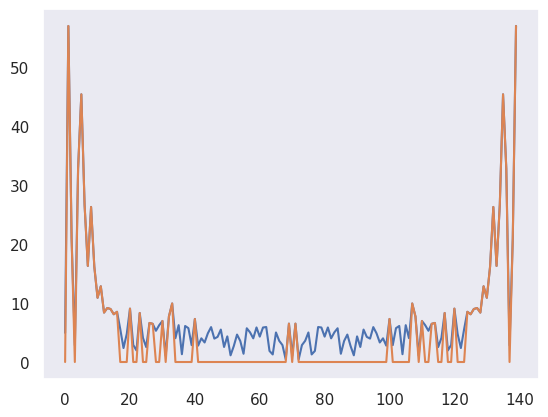

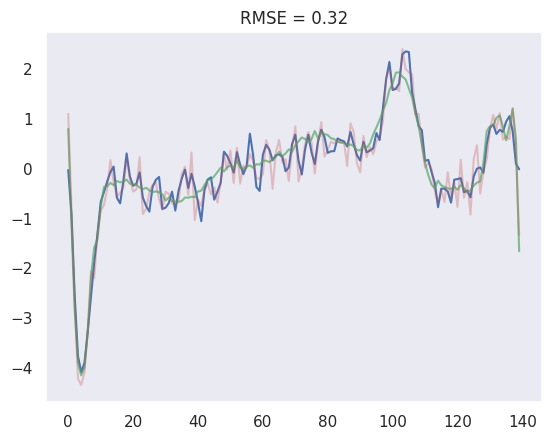

In [12]:
fourier = np.fft.fft(noisy_line)
plt.plot(np.abs(fourier))
threshold_percents = np.linspace(0.01, 0.99, 20)

best_rmse = 1

for thresh in tqdm(threshold_percents):
    fourier_shrink = fourier * (np.abs(fourier) > thresh*np.max(np.abs(fourier)))
    denoised_line = np.real(np.fft.ifft(fourier_shrink))
    rmse, snr, prd, d_max = metrics(line, denoised_line)
    if rmse < best_rmse:
        best_rmse = rmse
        best_thresh = thresh


fourier_shrink = fourier * (np.abs(fourier) > best_thresh*np.max(np.abs(fourier)))
denoised_line = np.real(np.fft.ifft(fourier_shrink))
print("Best threshold : ", best_thresh)
plt.plot(np.abs(fourier_shrink))
plt.show()

rmse, snr, prd, d_max = metrics(line, denoised_line)
plt.plot(denoised_line)
plt.plot(line, 'g', alpha = 0.7)
plt.plot(noisy_line, 'r', alpha = 0.3)
plt.title("RMSE = " + str(round(rmse, 2)))
plt.show()



(140,)
11.19842132272934


Text(0.5, 1.0, 'RMSE = 0.2752591724117021')

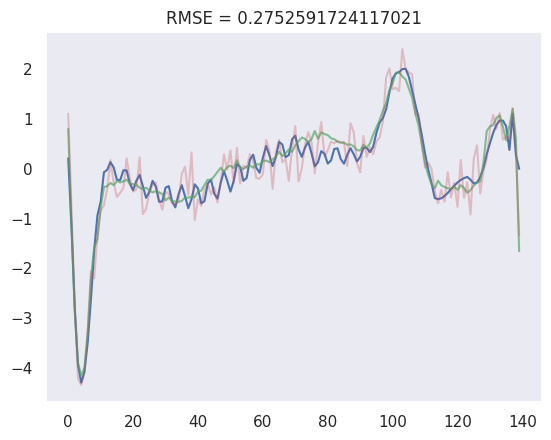

In [13]:
D = buildDictionary(noisy_line, [2, 4, 8, 16, 32, 64])
support, norm_residuals, denoised_line = orthogonalMatchingPursuit(noisy_line, D, 10)

print(denoised_line.shape)
print(10 * np.log10(np.var(denoised_line) / np.var(line-denoised_line)))
RMSE = np.sqrt(np.mean((line-denoised_line)**2))
plt.plot(denoised_line)
plt.plot(line, 'g', alpha = 0.7)
plt.plot(noisy_line, 'r', alpha = 0.3)
plt.title("RMSE = " + str(RMSE))

# Algorithms comparison

In [14]:
list_SNR = [i for i in range(20)] #the list of SNR noises we want to try
precision = 3

#list of parameters we are going to test 
levels = [2,3,4]
alpha_1 = 0.015

threshold_percents = np.linspace(0.1, 1, 20)

threshold_percents_fourier = np.linspace(0.01, 0.99, 20)


#building the dataframe to store the results 
columns_name = ["SNR = " + str(list_SNR[i]) for i in range(len(list_SNR))]
lines_name = ["Iterative Wavelet", "Basic Wavelet", "Fourier Shrink", "Dictionnary Method"]
res_df = pd.DataFrame(index = lines_name, columns=columns_name)

for k in tqdm(range(len(list_SNR))):
    noisy_line, _, noise = addNoise(line, list_SNR[k])

    #iterative wavelet
    best_prd = 1
    for i, waveletname in enumerate(pywt.wavelist(kind = 'discrete')):
        for j, level in enumerate(levels):
            denoised_line = iterativeWaveletDenoising(noisy_line, waveletname, level, alpha_1)
            mse, snr, prd, d_max = metrics(line, denoised_line)
            if prd < best_prd:
                best_prd = prd
                best_wavelet = waveletname
                best_level = level

        

    20
    denoised_line = iterativeWaveletDenoising(noisy_line, best_wavelet, best_level, alpha_1)
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[0],columns_name[k]] = round(mse,precision)

    #basic wavelet
    best_prd = 1
    for waveletname in pywt.wavelist(kind = 'discrete'):
        for thresh in threshold_percents:
            for level in levels:
                denoised_line = baselineWaveletDenoising(noisy_line, waveletname, level, thresh)
                mse, snr, prd, d_max = metrics(line, denoised_line)
                if prd < best_prd:
                    best_prd = prd
                    best_wavelet = waveletname
                    best_level = level
                    best_thresh = thresh

    denoised_line = baselineWaveletDenoising(noisy_line, best_wavelet, best_level, best_thresh) 
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[1],columns_name[k]] = round(mse,precision)




    #fourier threshold
    fourier = np.fft.fft(noisy_line)
    best_rmse = 1

    for thresh in threshold_percents_fourier:
        fourier_shrink = fourier * (np.abs(fourier) > thresh*np.max(np.abs(fourier)))
        denoised_line = np.real(np.fft.ifft(fourier_shrink))
        mse, snr, prd, d_max = metrics(line, denoised_line)
        if rmse < best_rmse:
            best_rmse = rmse
            best_thresh = thresh


    fourier_shrink = fourier * (np.abs(fourier) > best_thresh*np.max(np.abs(fourier)))
    denoised_line = np.real(np.fft.ifft(fourier_shrink))
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[2],columns_name[k]] = round(mse,precision)



    #dictionnary method
    D = buildDictionary(noisy_line, [2, 4, 8, 16, 32, 64])
    support, norm_residuals, denoised_line = orthogonalMatchingPursuit(noisy_line, D, 10)
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[3],columns_name[k]] = round(mse,precision)

            

res_df

  0%|          | 0/20 [00:00<?, ?it/s]

/home/max/.local/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/home/max/.local/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/home/max/.local/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
100%|██████████| 20/20 [01:36<00:00,  4.84s/it]


,SNR = 0,SNR = 1,SNR = 2,SNR = 3,SNR = 4,SNR = 5,SNR = 6,SNR = 7,SNR = 8,SNR = 9,SNR = 10,SNR = 11,SNR = 12,SNR = 13,SNR = 14,SNR = 15,SNR = 16,SNR = 17,SNR = 18,SNR = 19
Iterative Wavelet,0.404,0.492,0.388,0.349,0.324,0.311,0.307,0.279,0.253,0.197,0.195,0.172,0.16,0.133,0.127,0.126,0.112,0.115,0.101,0.082
Basic Wavelet,0.4,0.482,0.396,0.353,0.337,0.305,0.299,0.282,0.258,0.201,0.195,0.18,0.161,0.142,0.138,0.131,0.12,0.103,0.099,0.081
Fourier Shrink,0.944,0.947,0.809,0.624,0.631,0.551,0.476,0.408,0.399,0.368,0.322,0.285,0.252,0.209,0.206,0.186,0.169,0.153,0.141,0.108
Dictionnary Method,0.695,0.674,0.642,0.544,0.518,0.459,0.406,0.304,0.329,0.35,0.304,0.273,0.264,0.284,0.263,0.309,0.245,0.335,0.278,0.266


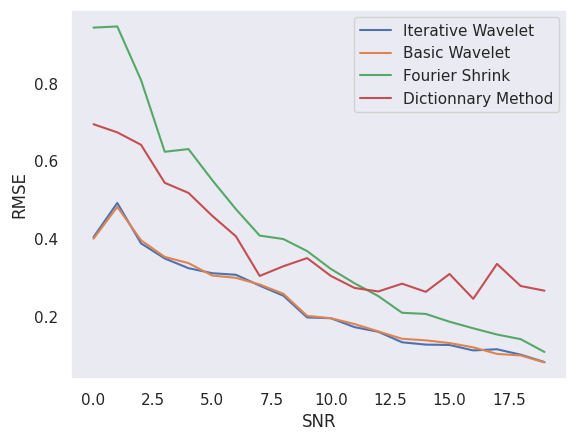

In [26]:
for i in range(4):
    plt.plot(list_SNR,res_df.iloc[i].tolist(),label = lines_name[i])
plt.xlabel("SNR")
plt.ylabel("RMSE")
plt.legend()
plt.show()